# Imporation

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import gc ,random 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn import model_selection

import cv2
import SimpleITK as sitk
from ipywidgets import interact, fixed
from tqdm import tqdm 
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import get_linear_schedule_with_warmup
import albumentations as A 
from transformers import AdamW

from collections import OrderedDict
from sklearn.model_selection import train_test_split

from loss.dice import * 
from loss.ssim import * 
from models import *
from datasets.merging_dataset import * 

In [3]:
# SEED Everything 

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Model Description 

## Generative adversarial network 

Te generative adversarial network, which consists of two components: a generator G
and a discriminator D, is a deep learning framework that trains the generative model and
the discriminative model alternately. The general idea of the generative adversarial network is an adversarial process amongst the models pitting against each other to improve the performance of the networks, where the generator counterfeits the sample images to
deceive the discriminator and the discriminative model determines whether the images are
fake or not. 

![](https://nhoues.github.io/Segmentation-of-hippocampal/Images/GAN.PNG)

In our case, we will use the generative model to generate the segmentation of the hippocampus in the brain. and then the adversarial model try to discriminate the generative segmentations from the expert manual segmentations.

## Generative network

we have used the **UNet** architecture as an Generative network in our Model.

## Adversarial network  

![](https://nhoues.github.io/Segmentation-of-hippocampal/Images/Adversial.PNG)

The adversarial model takes the hipocampal image and the corresponding label map as input. The label map is either the
expert segmentations or produced by the generative model. then  a binary class probability
is produced to determine whether the label map is the expert segmentation or not.

## Loss function 

The Loss function formula of the generative adversarial network is as follows:


$$ l(\:\theta_g ,\:\theta_a\:) = \sum_{n=1}^{N} \: \:\:l_{mce}(g(x_n),y_n) - [ \: l_{bce}(\:a(x_n,y_n),1\:) + l_{bce}(\:a(x_n,g(x_n)),0\:)\:]$$

Where :
* $x_n$ denotes input image  with the size of H×W
* $y_n$ corresponding label maps of $x_n$  
* $g(x) $  denotes the class probability map over M classes
* a(x, y)∈[0,1]  denotes the probability predicted by the adversarial model
*  $\theta_g$, $\theta_a$ are the parameters of the generative model and of the adversarial model respectively.
* $ l_{mce}( \hat{y} , y ) = - \sum_{i=1}^{H \times W }\: \sum_{m=1}^{M} \: y_{im} ln (\hat{y_{im}}) $ : denotes the multiclass cross-entropy loss 

* $ l_{bce}(\hat{a} ,a ) = = − a \: ln (\hat{a}) + (1 − a) \:ln( 
1 − \hat{a}) $ : denotes the binary cross entropy loss . 

When training the generative model, we minimize the loss with respect to θg, while maximizing it with respect to θa when training the
adversarial model.

# Engine 

In [5]:
def cross_entropy_loss(pred, target) : 
    return nn.CrossEntropyLoss()(pred,target)

In [7]:
def train_fn( data_loader , netG , netD , optimizerG , optimizerD ):
    netG.train()
    netD.train()
    
    D_loss = 0 
    G_loss = 0 
    counter = 0 
    train_dice = 0 
    if verbose : 
        tk0 = tqdm( enumerate(data_loader) , total= len(data_loader) )
    else : 
        tk0 = enumerate(data_loader) 
    for bi, d in tk0 :   
        
        y = d["label"].to(device, dtype=torch.float)
        x = d["LR"].to(device, dtype=torch.float) 
        BATCH_SIZE = y.shape[0]
        
        ### Train The Genrative model  torch.argmax(one_hot, dim=1)
        netG.zero_grad()    

        label  =Variable( (torch.ones(BATCH_SIZE)).to(device , dtype = torch.long) ) 
        generated = netG(x.unsqueeze(1)) 
        y_1 = torch.argmax(nn.Softmax2d()(generated) , dim=1)
        x_label_0 = (y_1==0).type(torch.long).unsqueeze(1)
        x_label_1 = (y_1==1).type(torch.long).unsqueeze(1)
        x_label_2 = (y_1==2).type(torch.long).unsqueeze(1)
        x_label_3 = (y_1==3).type(torch.long).unsqueeze(1)
        generated_segmenation = torch.cat([x_label_0,x_label_1,x_label_2,x_label_3] , dim = 1)
        generated_segmenation = generated_segmenation.type(torch.float)
    #  generated_segmenation = 
        im = torch.cat([x.unsqueeze(1),generated_segmenation] , dim = 1 )
        output_g = netD( im.detach() )
        lossG_seg ,_  = dice_loss(generated,y)
        train_dice += lossG_seg.item()
        lossG_class = cross_entropy_loss(output_g, label)
        lossG = lossG_seg * alpha  + lossG_class * (1-alpha)
        G_loss += lossG.item() 
        lossG.backward(retain_graph=True)
        optimizerG.step()
        
        ### Train the Adversial model 
        netG.zero_grad() 
        netD.zero_grad()    
      
        label  = Variable((torch.ones(BATCH_SIZE)).to(device , dtype = torch.long))
        im = torch.cat([x.unsqueeze(1),y] , dim = 1 )
        output = netD(im)
        lossD_real  = cross_entropy_loss(output, label)
        
        label = Variable((torch.zeros(BATCH_SIZE)).to(device, dtype = torch.long))
        lossD_fake  = cross_entropy_loss(output_g, label)
        
        lossD = (lossD_real + lossD_fake)/5
        D_loss += lossD.item()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        
        counter += 1 
    return G_loss/counter , D_loss/counter  , train_dice/counter

In [8]:
def eval_fn(data_loader, model):
    model.eval()
    tr_loss = 0
    counter = 0
    
    label1_loss  = 0
    label2_loss  = 0 
    label3_loss  = 0 
   
    if verbose : 
        tk0 = tqdm( enumerate(data_loader) , total= len(data_loader) )
    else : 
        tk0 = enumerate(data_loader) 

    with torch.no_grad():
        
        for bi, d in tk0 :
       
            y = d["label"].to(device, dtype=torch.long)

            x = d["LR"].to(device, dtype=torch.float) 

            y_hat   = model(x.unsqueeze(1)) #forward prop
            
            
            loss , labels = dice_loss(y_hat, y) # Loss calaculation of batch i 
            
            label1_loss += labels[0].item() 
            label2_loss += labels[1].item() 
            label3_loss += labels[2].item() 
            tr_loss += loss.item()
            counter +=1 
    return tr_loss/counter ,  (label1_loss /counter ,label2_loss /counter, label3_loss /counter)

In [9]:
def run(netD,netG):
    
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        shuffle = True , 
        batch_size=TRAIN_BATCH_SIZE,
        num_workers=8
    )
    
    
    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        num_workers=4
    )
    # Setup Optimizer for G and D
    optimizerD =optim.Adam(netD.parameters(), lr=lr)  
    optimizerG = optim.Adam(netG.parameters(), lr=lr)  
    
    best_validation_dsc = 1.0
    patience = 0 
    
    summary = dict() 
    all_D_Loss = []
    all_G_Loss = [] 
    all_train_dice = [] 
    all_val_dic = []
    
    print(f'fold {f} .... ')
    for epoch in range(EPOCHS):
        
        if verbose : 
            print(f'--------- Epoch {epoch} ---------')
        elif epoch%10==0 : 
            print(f'--------- Epoch {epoch} ---------')
       
        G_loss ,D_loss ,train_dice  = train_fn(train_data_loader, netG , netD , optimizerG , optimizerD)
        all_D_Loss.append(D_loss) 
        all_G_Loss.append(G_loss)
        all_train_dice.append(1 - train_dice)
        if verbose :
            print(f"D_loss  = {D_loss}       ,     G_loss  = {G_loss}   ,        train_dice = {train_dice}")
        elif epoch%10==0 : 
            print(f"D_loss  = {D_loss}       ,     G_loss  = {G_loss}   ,        train_dice = {train_dice}")
        val , _  = eval_fn(valid_data_loader, netG)
        all_val_dic.append(1 - val)
        if verbose :
            print(f" val_loss  = {val}")
        elif epoch%10==0 :  
            print(f" val_loss  = {val}")
        if val < best_validation_dsc : 
            best_validation_dsc =val 
            patience = 0 
            torch.save(netG.state_dict(), 'SnetG.pt')
            torch.save(netD.state_dict(), 'SnetD.pt')
        else : 
            patience +=1
        
        if patience>25 : 
            print(f'Eraly Stopping on Epoch {epoch}')
            print(f'Best Loss =  {best_validation_dsc}')
            break
    summary['generator Loss'] = all_G_Loss
    summary['discriminator  Loss'] = all_D_Loss
    summary['Train Dice score'] = all_train_dice
    summary['Val Dice score'] = all_val_dic
    netG.load_state_dict(torch.load('SnetG.pt'), strict=False)
    netD.load_state_dict(torch.load('SnetD.pt'), strict=False)
    return summary 

# Training

In [10]:
data = pd.read_csv('data_5fold.csv')
subjects = data[data['slice']==0]

In [11]:
EPOCHS = 200
device = torch.device('cuda')
VALID_BATCH_SIZE = 32
TRAIN_BATCH_SIZE = 16
lr = 0.0003
alpha = 0.5
verbose = False 

In [ ]:
results = []
for f in range(5) : 
    df_train = data[data['kfold'] !=f]
    df_valid = data[data['kfold'] ==f]
    train_dataset = Merging_data_set(df_train ,  subjects  , Left = True , is_train = True)
    valid_dataset = Merging_data_set(df_valid  ,  subjects  , Left = True , is_train  = False)
    netG = UNet(1,4)
    netD = SegmenationAdeversarial()
    netG = netG.to(device)
    netD = netD.to(device)
    r = run(netD,netG)
    results.append(r)
    torch.save(netG.state_dict(), f'trained_model/GAN_segmentation/GAN Left fold {f}.pt')

[get_training_augmentation]  resize_to: (160, 160)
fold 0 .... 
--------- Epoch 0 ---------
D_loss  = 0.21975853664791165       ,     G_loss  = 0.8592063389231811   ,        train_dice = 0.7375784276717872
 val_loss  = 0.6864864373207092
--------- Epoch 10 ---------
D_loss  = 0.2085230824486095       ,     G_loss  = 0.5417689007131299   ,        train_dice = 0.10408198693065188
 val_loss  = 0.10551691204309463
--------- Epoch 20 ---------
D_loss  = 0.194237696690176       ,     G_loss  = 0.5655636637654137   ,        train_dice = 0.09635520294009142
 val_loss  = 0.09123184576630593
--------- Epoch 30 ---------
D_loss  = 0.1921722331088991       ,     G_loss  = 0.5650321260169523   ,        train_dice = 0.08755237710236305
 val_loss  = 0.09902554392814636
--------- Epoch 40 ---------
D_loss  = 0.1931795247984891       ,     G_loss  = 0.5598195446795554   ,        train_dice = 0.08243283127720033
 val_loss  = 0.09504964411258697
--------- Epoch 50 ---------
D_loss  = 0.1921277770295215  

In [20]:
def plot_train(f):
    plt.plot(results[f]['generator Loss']) 
    plt.plot(results[f]['discriminator  Loss'])
    plt.title('Generator vs Discriminator')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Generator', 'Discriminator'], loc='upper right')
    plt.show()
def plot_score(f):
    plt.plot(results[f]['Train Dice score']) 
    plt.plot(results[f]['Val Dice score'])
    plt.title('Train vs Val')
    plt.ylabel('score')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.show()

# Fold 0 

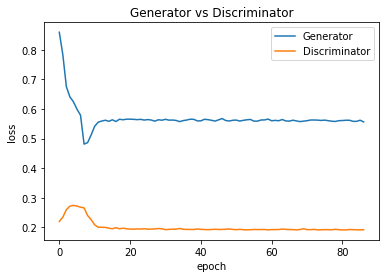

In [21]:
plot_train(0)

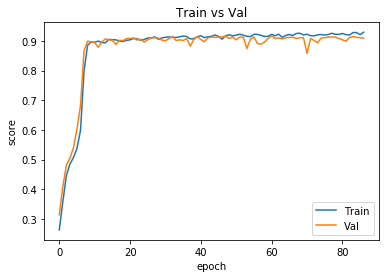

In [22]:
plot_score(0)

# Fold 1

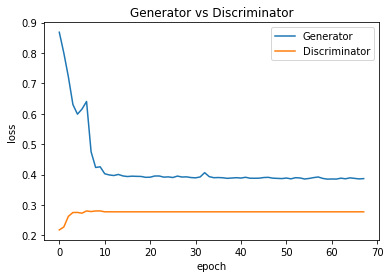

In [23]:
plot_train(1)

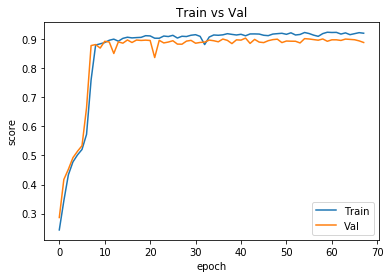

In [24]:
plot_score(1)

# Fold 2 

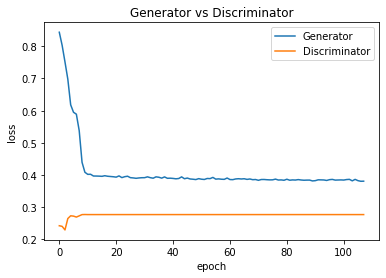

In [25]:
plot_train(2)

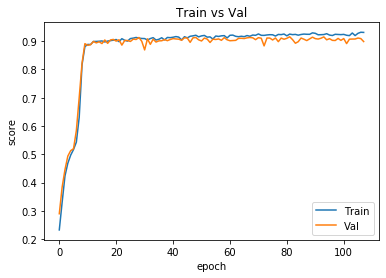

In [26]:
plot_score(2)

# Fold 3 

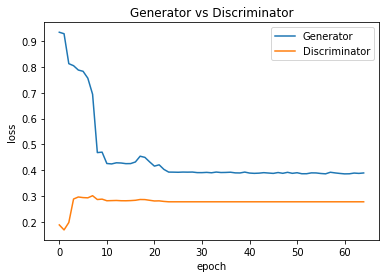

In [27]:
plot_train(3)

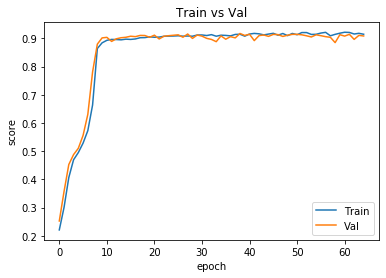

In [28]:
plot_score(3)

# Fold 4 

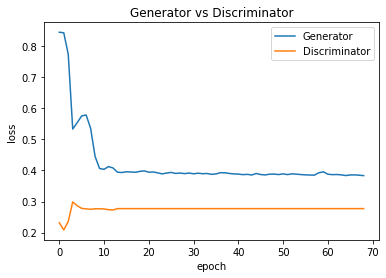

In [29]:
plot_train(4)

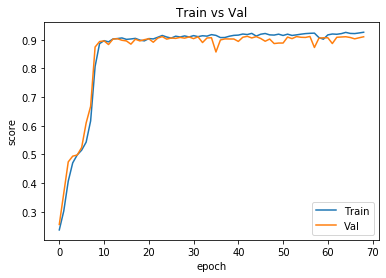

In [30]:
plot_score(4)